In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from PIL import Image
import time
import sklearn.metrics
import random
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [2]:
# set run parameters

batch_size = 32

In [3]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

torch.multiprocessing.set_sharing_strategy('file_system')

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [4]:
# create a dataset class

class Cifar10Dataset(Dataset):
    def __init__(self, data, targets, transform):
        self.transform = transform
        self.data = data 
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [9]:
# create datasets

preprocess = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# split train data into train and validation sets without changing class distribution
cifar10 = CIFAR10(root='./../../data', train=True, download=True, transform=preprocess)
data_train, data_valid, targets_train, targets_valid = train_test_split(cifar10.data, cifar10.targets, test_size=0.2, stratify=cifar10.targets)

# for consistency's sake
cifar10_test = CIFAR10(root='./../../data', train=False, download=True, transform=preprocess)


# 66.66%
trainDataset = Cifar10Dataset(data_train, targets_train, transform=cifar10.transform)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

# 16.66%
validDataset = Cifar10Dataset(data_valid, targets_valid, transform=cifar10.transform)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

# 16.66%
testDataset = Cifar10Dataset(cifar10_test.data, cifar10_test.targets, transform=cifar10_test.transform)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)


labelDescription = cifar10.classes

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# create a class that will inverse the normalization of an image

class Denormalizer(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

denormalizer = Denormalizer(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

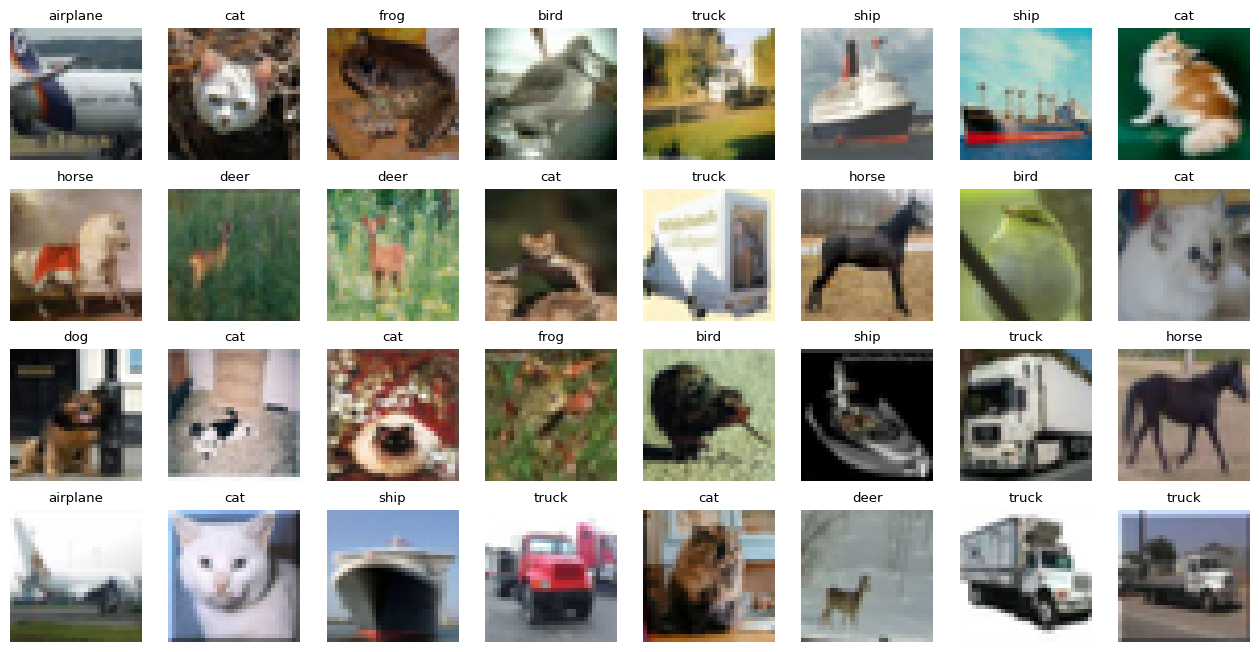

In [11]:
# show single batch of data

images_batch, labels_batch = next(iter(trainLoader))

plt.figure(figsize=(16,8))
plt.rc('font', size=8)

for i in range(len(labels_batch)):
    plt.subplot(4,8,i+1)
    plt.imshow(denormalizer(images_batch[i]).permute(1,2,0))
    plt.title(labelDescription[labels_batch[i]])
    plt.axis('off')


plt.ioff()
plt.show()

In [45]:
# define the model

class Cifar10Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchNorm1 = nn.BatchNorm2d(num_features=32)
        self.batchNorm2 = nn.BatchNorm2d(num_features=64)
        self.batchNorm3 = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.batchNorm1(F.relu(self.conv1(x)))
        x = self.batchNorm1(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.batchNorm2(F.relu(self.conv3(x)))
        x = self.batchNorm2(F.relu(self.conv4(x)))
        x = self.pool(x)
        x = self.batchNorm3(F.relu(self.conv5(x)))
        x = self.batchNorm3(F.relu(self.conv6(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


modeltest = Cifar10Net()
summary(modeltest, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Conv2d: 1-3                            [-1, 32, 32, 32]          9,248
├─BatchNorm2d: 1-4                       [-1, 32, 32, 32]          (recursive)
├─MaxPool2d: 1-5                         [-1, 32, 16, 16]          --
├─Conv2d: 1-6                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-7                       [-1, 64, 16, 16]          128
├─Conv2d: 1-8                            [-1, 64, 16, 16]          36,928
├─BatchNorm2d: 1-9                       [-1, 64, 16, 16]          (recursive)
├─MaxPool2d: 1-10                        [-1, 64, 8, 8]            --
├─Conv2d: 1-11                           [-1, 128, 8, 8]           73,856
├─BatchNorm2d: 1-12                      [-1, 128, 8, 8]           256
├─Conv2d: 1-13                           [-1, 128

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Conv2d: 1-3                            [-1, 32, 32, 32]          9,248
├─BatchNorm2d: 1-4                       [-1, 32, 32, 32]          (recursive)
├─MaxPool2d: 1-5                         [-1, 32, 16, 16]          --
├─Conv2d: 1-6                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-7                       [-1, 64, 16, 16]          128
├─Conv2d: 1-8                            [-1, 64, 16, 16]          36,928
├─BatchNorm2d: 1-9                       [-1, 64, 16, 16]          (recursive)
├─MaxPool2d: 1-10                        [-1, 64, 8, 8]            --
├─Conv2d: 1-11                           [-1, 128, 8, 8]           73,856
├─BatchNorm2d: 1-12                      [-1, 128, 8, 8]           256
├─Conv2d: 1-13                           [-1, 128

In [49]:
# train

model = Cifar10Net().to(device)

criterion = nn.CrossEntropyLoss()
lr = 6e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold_mode='abs') 
batch_print_step = 250
epochs = 150

best_train_loss = float('inf')
best_val_loss = float('inf')

train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []

for epoch in range(epochs):
    # index 0 is for training, index 1 for validation
    epoch_loss = [0, 0]
    accuracy = [0, 0]
    f1_score = [0, 0]
    epochtime = time.time()
    
    for dataset, dataloader, isTraining in [(trainDataset, trainLoader, True), (validDataset, validLoader, False)]:
        correct = 0
        running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []

        if isTraining:
            model.train()
        else:
            model.eval()

        for i, data in enumerate(dataloader, 0):        
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            if isTraining:
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward 
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)

            if isTraining:
                # backward + optimize
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item() * images.size(0)
            correct += torch.sum(predicted == labels.data)
            all_predicted_labels.append(predicted.cpu())
            all_input_labels.append(labels.cpu())
            
            if i % batch_print_step == batch_print_step-1:
                print("\r", f'{"TRAINING" if isTraining else "VALIDATION"} PROGRESS [epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(dataset):.3f}%, {math.floor(time.time() - epochtime):3d}s] loss: {running_loss / len(dataset):.3f}', end="")
                timestart = time.time()
        
        index = 0 if isTraining else 1
        epoch_loss[index] = running_loss / len(dataset)
        accuracy[index] = correct.double() / len(dataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score[index] = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

    print("\r" + f'EPOCH: [{epoch + 1:2d}/{epochs}, time: {math.floor(time.time() - epochtime)}s]   TRAIN: [loss: {epoch_loss[0]:.3f}, acc: {accuracy[0]:.3f}, f1: {f1_score[0]:.3f}]   VAL: [loss: {epoch_loss[1]:.3f}, acc: {accuracy[1]:.3f}, f1: {f1_score[1]:.3f}]   learning_rate: {lr}') 
    train_loss_history.append(epoch_loss[0])
    val_loss_history.append(epoch_loss[1])
    train_f1_history.append(f1_score[0])
    val_f1_history.append(f1_score[1])

    scheduler.step(epoch_loss[1])
    lr = scheduler.get_last_lr()

print('done')

EPOCH: [ 1/150, time: 18s]   TRAIN: [loss: 1.707, acc: 0.477, f1: 0.476]   VAL: [loss: 2.290, acc: 0.333, f1: 0.287]   learning_rate: 0.006
EPOCH: [ 2/150, time: 19s]   TRAIN: [loss: 0.901, acc: 0.681, f1: 0.680]   VAL: [loss: 1.197, acc: 0.587, f1: 0.575]   learning_rate: [0.006]
EPOCH: [ 3/150, time: 18s]   TRAIN: [loss: 0.705, acc: 0.754, f1: 0.753]   VAL: [loss: 1.233, acc: 0.568, f1: 0.547]   learning_rate: [0.006]
EPOCH: [ 4/150, time: 18s]   TRAIN: [loss: 0.585, acc: 0.795, f1: 0.795]   VAL: [loss: 1.569, acc: 0.463, f1: 0.448]   learning_rate: [0.006]
EPOCH: [ 5/150, time: 18s]   TRAIN: [loss: 0.492, acc: 0.826, f1: 0.826]   VAL: [loss: 1.250, acc: 0.551, f1: 0.542]   learning_rate: [0.006]
EPOCH: [ 6/150, time: 18s]   TRAIN: [loss: 0.311, acc: 0.898, f1: 0.898]   VAL: [loss: 1.185, acc: 0.573, f1: 0.570]   learning_rate: [0.00030000000000000003]
EPOCH: [ 7/150, time: 19s]   TRAIN: [loss: 0.267, acc: 0.916, f1: 0.916]   VAL: [loss: 1.165, acc: 0.582, f1: 0.580]   learning_rate:

KeyboardInterrupt: 

In [50]:
# test 

model.eval()

test_running_loss = 0
correct = 0
all_predicted_labels = []
all_input_labels = []

for i, data in enumerate(testLoader, 0):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    test_running_loss += loss.item() * images.size(0)
    correct += torch.sum(predicted == labels.data)
    all_predicted_labels.append(predicted.cpu())
    all_input_labels.append(labels.cpu())

final_loss = test_running_loss / len(testDataset)
accuracy = correct.double() / len(testDataset)
all_input_labels = np.concatenate(all_input_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)
f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

print(f'[TEST] loss: {final_loss:.3f}, accuracy: {accuracy:.3f}, f1_score: {f1_score:.3f}')

# show confusion matrix
print(', '.join([labelDescription[i] for i in range(10)]))
print(confusion_matrix(all_input_labels, all_predicted_labels, labels=[i for i in range(10)]))

[TEST] loss: 1.291, accuracy: 0.551, f1_score: 0.552
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
[[682   0   6   1  58   2   2   4 245   0]
 [ 55 485   1   1  44   0   3   2 383  26]
 [ 76   0 359   6 410  18  34   7  90   0]
 [ 42   1  44 171 451  62  69   9 151   0]
 [  8   0   4   1 956   1   4   2  24   0]
 [ 17   1  43  42 370 384  43  23  77   0]
 [  9   0  14   2 350   5 552   2  66   0]
 [ 47   0  17   9 352  10   5 529  31   0]
 [ 12   1   2   0  22   0   4   0 958   1]
 [106  16   4   1  74   1   5   7 355 431]]


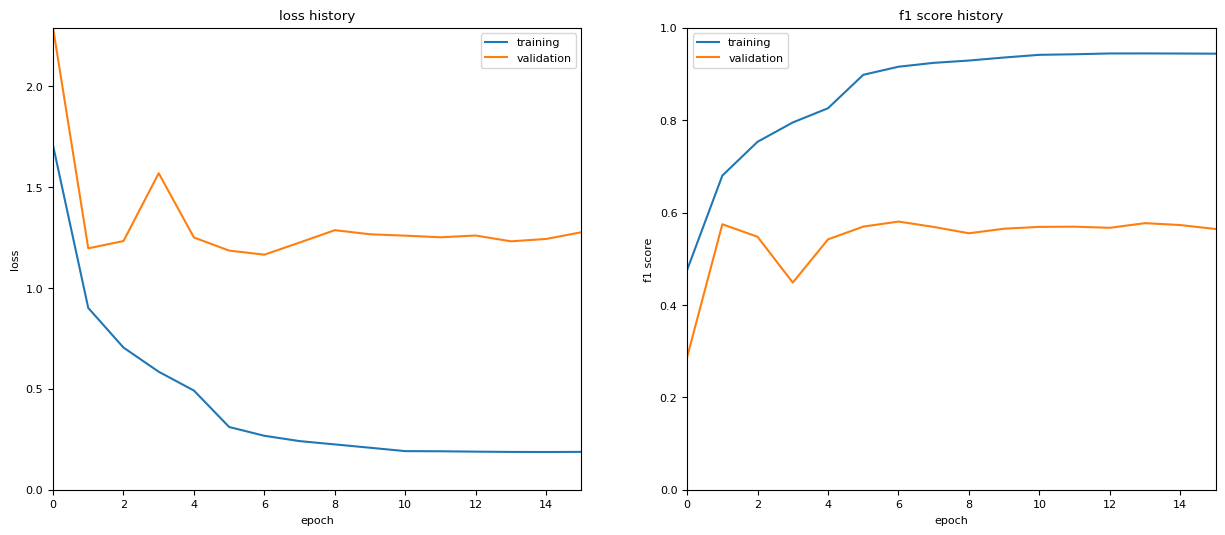

In [53]:
# plot train and validation loss

plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0, 15)#len(train_loss_history))
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)))
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['training', 'validation'])

plt.subplot(1, 2, 2)
plt.title('f1 score history')
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.xlim(0, 15)#len(train_f1_history))
plt.ylim(0, 1)
plt.plot(train_f1_history)
plt.plot(val_f1_history)
plt.legend(['training', 'validation'])

plt.show()